# Sentinel-2 Datenverarbeitungs-Pipeline mit QGIS und Python

In [2]:
# Importbefehle sämtlicher Schritte ohne QGIS

import os
import rasterio
import matplotlib.pyplot as plt

In [ ]:
import processing

In [ ]:
# Importbefehle QGIS

from qgis.core import QgsProject, QgsVectorLayer, QgsRasterLayer

In den folgenden Schritten werden am Beispiel Uruguays mögliche Schritte der Datenverarbeitung von Sentinel-2-Daten aufgearbeitet und umgesetzt. Dabei werden Geoverarbeitungsschritte mit PyQGIS-Code eingebaut sowie verschiedene Methodikansätze getestet, die anschließend je nach Anwendungsfeld eingesetzt werden können. 

Es ist möglich, mittels Bau eines QGIS-Plugins direkt Daten vom Copernicus Dataspace zu beziehen. Dafür würde ein Authentifizierungsmodul mit Verwaltung der Zugangsdaten, automatischer Token-Erneuerung etc. benötigt werden, ebenso mit Qt Designer umsetzbare GUI-Elemente und spezifischen Code zur API-Integration und Umsetzung im GIS. Praktisch gibt es schon den "Sentinel-2 Image Downloader" von Murat Çalışkan zum kostenlosen Download als QGIS-Plugin.

## Sentinel-2 Daten herunterladen 

Wir nutzen nicht den manuellen Weg über den Copernicus Dataspace, sondern verwenden das erwähnte Sentinel-2-Downloadplugin. Als Datenvorbereitung habe ich die administrative level 0-2 boundaries von Uruguay als .shp heruntergeladen und in QGIS dissolved, um die Landfläche des Staates zu erhalten. 

In [ ]:
# Ansatz direkt in der QGIS Python-Konsole
params = {'INPUT':"C:/", # hier richtigen pfad einfuegen
          'FIELD':[],
          'SEPARATE_DISJOINT':False,
          'OUTPUT':'TEMPORARY_OUTPUT'}

processing.run("native:dissolve", params)

# Alternativ ohne Code als Geoverarbeitungswerkzeug in QGIS: Vector geometry --> Dissolve

# Ergebnis nach Belieben abspeichern

Im Plugin wählen wir als erstes bei "Download Footprints" unseren Layer aus und klicken auf "Layer Extent". Max. Cloud 10%, Product Type L1C (es gibt kein L2A für Uruguay), Start- und Enddatum den September 2025. Wir geben einen Outputfolder an.

Als Überprüfung des Layers und der Korrektheit der Bounding-Box (um Fehlern vorzubeugen) nutzte ich Code aus dem "bounding_box_aller_layer.py"-Skript, um uns die räumliche Ausdehnung unseres Shapefiles ausgeben zu lassen. 

In [ ]:
"""
BOUNDING BOX VON EINEM LAYER 
"""


layer_name = "landflaeche_uruguay"
einzelner_layer = QgsProject.instance().mapLayersByName(layer_name)[0]

if einzelner_layer and isinstance(einzelner_layer, QgsVectorLayer):
    
     extent = einzelner_layer.extent()

     xmin = extent.xMinimum()
     xmax = extent.xMaximum()
     ymin = extent.yMinimum()
     ymax = extent.yMaximum()

     print(f"Bounding-Box des Layers {einzelner_layer.name()}:")
     print(f"  Xmin: {xmin:.8f}")
     print(f"  Xmax: {xmax:.8f}")
     print(f"  Ymin: {ymin:.8f}")
     print(f"  Ymax: {ymax:.8f}")

     bbox_coords = (xmin, xmax, ymin, ymax)

Unser Ergebnis in der QGIS-Python-Konsole: 

Bounding-Box des Layers landflaeche_uruguay:
  Xmin: -58.44272232
  Xmax: -53.09424591
  Ymin: -34.97402954
  Ymax: -30.079689038913

Das Ergebnis war korrekt und stimmte mit der Ausgabe des Plugins überein. In unserem Fall wurden nach Abzug der Duplikate 14 Bilder gefunden. Der anschließende "Running"-Prozess kann etwas dauern.
Bei "Download Images" loggen wir uns mit den Copernicus-Logindaten ein, wählen das im vorherigen Schritt erstellte GPKG als Input aus, erneut unseren Output-Ordner sowie bei "OPTIONS" die gewünschten Bänder. Für diese Auswertung werden das True Color Image (TCI) sowie die Bänder B02, B03, B04, B05, B06, B08 und B11 heruntergeladen. 
Es kann auch ein kleineres Untersuchungsgebiet gewählt werden, in meinem Fall werden nun 89 Bilder à ca. 400 MB Daten heruntergeladen. Das hat den Vorteil eines sehr großen Datensatzes für Machine Learning Methoden, Datenvalidierung und mehr, ist aber speicherintensiv. 

In [4]:
sentinel_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay"

## True Color Images in QGIS einladen

In [ ]:
for root, dirs, files in os.walk(sentinel_path):
    for file in files:
        if file.endswith("TCI.jp2"):
            full_path = os.path.join(root, file)
            lyr = QgsRasterLayer(full_path, os.path.basename(full_path))
            QgsProject.instance().addMapLayer(lyr)

Er lädt in unserem Fall 86 True Color images ein. Durch die eingestellten 10% Max Cloud finden sich einzelne, wenige Wolkenbereiche. Durch die nodata bereiche der einzelnen Sentinel-Bilder werden auch andere Aufnahmen überlagert. Ein kleiner Bereich im Südosten Uruguays ist nicht von den Bildern abgedeckt, der Rest schon und teils mehrfach. 

## NoData-Bereiche aus den Rasterdaten entfernen 

Um im nächsten Schritt erste NDVI, NDWI,...-Darstellungen vornehmen zu können, müssen wir die sich überlagernden NoData-Bereche im Raster rausschneiden. Dafür laden wir die jeweiligen Bänder ein (bspw. Band 03 und 08 für NDWI) und schneiden sie per Geoprocessingtool und PyQGIS zu. die neuen bänder werden im selben ordner mit _cut am Ende gespeichert.
Das Ganze machen wir 2x, bevor wir einen ersten Index berechnen können. 

In [ ]:
# mit einem Band testen . in qgis ausführen. 

testbild_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HUB_20250911T183814\T21HUB_20250911T133829_B03.jp2"

lyr = QgsRasterLayer(testbild_path, os.path.basename(testbild_path))

cut_path = os.path.splitext(testbild_path)[0] + "_cut.tif"

params = {
    'INPUT': testbild_path,
    'TARGET_CRS': None,
    'NODATA': 0,              
    'COPY_SUBDATASETS': False,
    'OPTIONS': 'COMPRESS=ZSTD|PREDICTOR=2|TILED=YES|ZSTD_LEVEL=9', # um dateigroeße zu senken
    'DATA_TYPE': 0,
    'OUTPUT': cut_path
}
processing.run("gdal:translate", params)

QgsProject.instance().addMapLayer(QgsRasterLayer(cut_path, os.path.basename(cut_path)))

print(f"Gespeichert: {cut_path}")

In [ ]:
# für alle bänder

band = "B03" # ändern in TCI, B04, B05 etc. 


for root, dirs, files in os.walk(sentinel_path): # Hier den sentinel pfad von weiter oben vorher einladen
    for file in files:
        if file.endswith(f"{band}.jp2"): 
            full_path = os.path.join(root, file)

            lyr = QgsRasterLayer(full_path, os.path.basename(full_path))
            if not lyr.isValid():
                print(f"Fehler beim Laden: {full_path}")
                continue

            cut_path = os.path.splitext(full_path)[0] + "_cut.tif"

            params = {
                'INPUT': full_path,
                'TARGET_CRS': None,
                'NODATA': 0,              
                'COPY_SUBDATASETS': False,
                'OPTIONS': 'COMPRESS=LZW', # um dateigroeße zu senken, davor war export 10x größer als originaldatei
                'DATA_TYPE': 0,
                'OUTPUT': cut_path
            }
            processing.run("gdal:translate", params)

            QgsProject.instance().addMapLayer(QgsRasterLayer(cut_path, os.path.basename(cut_path)))

            print(f"Gespeichert: {cut_path}")eichert: {cut_path}")

**NUR bei falschem Export!**: Zugeschnittene Daten wieder löschen

In [5]:
for root, dirs, files in os.walk(sentinel_path):
    for file in files:
        if file.endswith("_cut.tif"):
            full_path = os.path.join(root, file)
            try:
                os.remove(full_path)
                print(f"Gelöscht: {full_path}")
            except Exception as error:
                print(f"{full_path}: {error} löschen nicht möglich. ")

Gelöscht: C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HUB_20250911T183814\T21HUB_20250911T133829_B03_cut.tif
Gelöscht: C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HVB_20250911T183814\T21HVB_20250911T133829_B03_cut.tif
Gelöscht: C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HVC_20250911T183814\T21HVC_20250911T133829_B03_cut.tif
Gelöscht: C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HVD_20250911T183814\T21HVD_20250911T133829_B03_cut.tif
Gelöscht: C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HVE_20250911T183814\T21HVE_20250911T133829_B03_cut.tif
Gelöscht: C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HWB_20250911T183814\T21

## Spektralindizes ausgeben lassen

Zur automatisierten Index-Berechnung ohne Umweg über den Rasterrechner oder Code kann mein Mini-Plugin "indices" aus diesem Repository genutzt werden, welches die gängigen Indices berechnet und das neue Raster direkt in QGIS einlädt. Für 86 files nutzen wir lieber eine Schleife. 
**Zum Test der Pipeline beschränken wir uns ab hier vorerst auf eins der Sentinel-Raster, um Speicherplatz und Geschwindigkeit zu optimieren. Final werden wir die implementierten Schritte auf alle 86 Rasterdateien anwenden.**

Unser erster Testlayer liegt gar nicht in Uruguay, sondern etwas südlich davon, am östlichen Stadtrand von Buenos Aires/Argentinien. Das Plugin berechnet den NDWI zuverlässig und gibt auch plausible Ergebnisse aus, die Gewässer und insb. das Meer mit klar positiven Werten von ca. 0,2 darstellen. Landfläche nimmt Werte von -0,4 bis -0,3 ein.

## Erstes NDWI-Ergebnis visualisieren

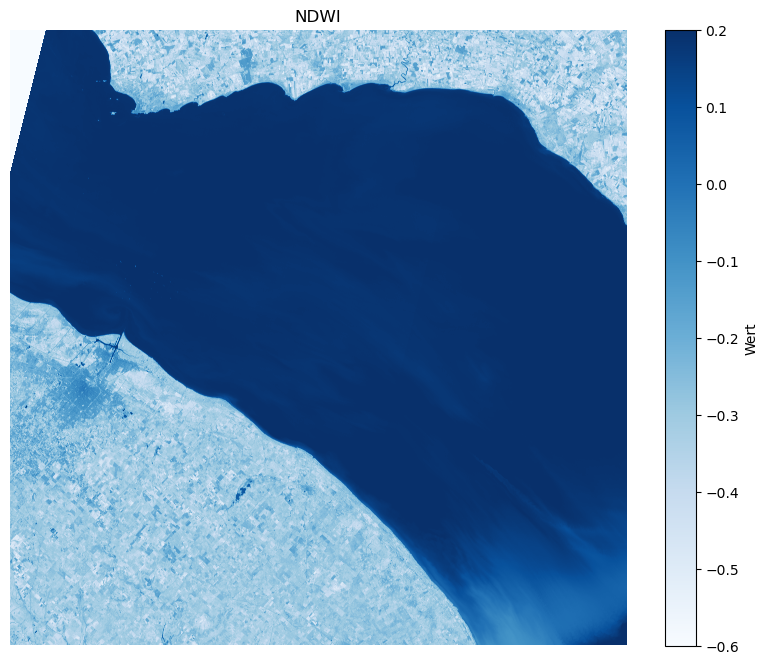

In [11]:
ndwi_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2B_MSIL1C_20250911T133829_N0511_R124_T21HVB_20250911T183814\NDWI.tif"

with rasterio.open(ndwi_path) as src:
    arr = src.read(1)  

plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
im = plt.imshow(arr, cmap=cmap, vmin=-0.6, vmax=0.2)
plt.colorbar(im, label="Wert")
plt.title("NDWI")
plt.axis('off')
plt.show()

Da sich das Preprocessing für terrestrische und aquatische Flächen unterscheidet, beginnen wir mit der Anwendung von Sen2Cor auf eine terrestrische Fläche. Für Gewässeroberflächen verwenden wir ACOLITE. Ein geeigneter Rasterausschnitt mit Wolken und viel terrestrischer Fläche befindet sich im Norden Uruguays und umfasst ebenso Landfläche Brasiliens. Im nachfolgenden Abschnitt wird er visualisiert.

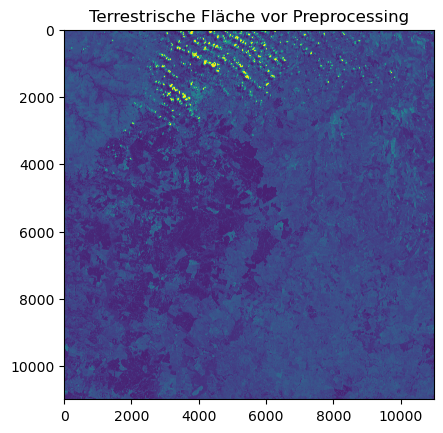

In [7]:
terr_raster_path = r"C:\Users\Daniel Koch\Desktop\Fernerkundung\Daten\Sentinel_Uruguay\S2C_MSIL1C_20250906T134231_N0511_R124_T21JXF_20250906T165922\T21JXF_20250906T134231_TCI.jp2"

with rasterio.open(terr_raster_path) as src:
    arr = src.read(1)  

plt.imshow(arr)
plt.title("Terrestrische Fläche vor Preprocessing")
plt.show()

Zur Maskierung der Wolken und dem Preprocessing TOA -> BOA unserer Rasterdatei laden wir eins der Bänder (z.B. B03 gruen) in SNAP ein (Sentinel Application Platform der ESA). Für Sen2Cor können wir das von SNAP unterstützte Plugin Sen2Cor nutzen, welches unter Tools -> Plugins zur Installation oder alternativ auf step.esa.int zum Download und anschließender Installation bereitsteht. Bei der Prozessierung werden auch automatisch Wolkenpixel ausgegeben. Für diese Auswertung wurde SNAP 11 und der Sen2Cor 2.12.0 Processor genutzt.



- Noch mehr Datenvorbereitung?

- Feature Engineering
- Anschließend: Random Forest und andere ML-Ansätze auf Sentinel-Bild anwenden? NDWI- und NDVI-Zeitreihen untersuchen etc.
Random Forest auch vorher/nachher zum Vergleich der Ergebnisse.